In [1]:
#!pip install tensorflow
#!pip install keras
import keras

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense,Dropout
import matplotlib.pyplot as plt
%matplotlib inline
# 會使用到一些內建的資料庫, MAC 需要加入以下兩行, 才不會把對方的 ssl 憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [4]:
print("訓練資料筆數:", len(y_train))
print("測試資料筆數:", len(y_test))

訓練資料筆數: 60000
測試資料筆數: 10000


In [5]:
print("特徵的維度:", x_train.shape)

特徵的維度: (60000, 28, 28)


In [6]:
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 10)

這是一個黑白圖像，每張圖是 28 * 28 pixel，每個 pixel 最大值 255(白) 最小值 0(黑)

In [7]:
# 取第一筆特徵來看
pd.DataFrame(x_train[0])

,0,1,2,3,4,...,23,24,25,26,27
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0
5,0,0,0,0,0,...,127,0,0,0,0
6,0,0,0,0,0,...,64,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
21,0,0,0,0,0,...,0,0,0,0,0
22,0,0,0,0,0,...,0,0,0,0,0


將資料做標準化(把所有的資料縮放到 0 - 1 間)

1. 希望所有特徵影響的幅度一樣，如果有個特徵區間明顯比別人大,那在梯度下降的時候就比較會傾向往它走

2. 如果特徵區間太大，一個梯度下降的步幅相對來說就比較大，很容易超過最低點

In [8]:
from keras.utils import np_utils
# reshape 讓圖從 28 * 28 變成 784 * 1 的一維陣列, 除以 255 讓我們標準化到 0-1 區間
x_train_shaped = x_train.reshape(60000, 784).astype("float32") / 255
x_test_shaped = x_test.reshape(10000, 784).astype("float32") / 255
# keras 要求分類輸出必須換成 One-hot 模式
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)

In [9]:
# One-hot 前後差別
print("One-hot 前:", y_train[0])
print("One-hot 後:", y_train_cat[0])

One-hot 前: 5
One-hot 後: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [10]:
# 利用 input 讓看看想看的圖片
a = int(input("請輸入想可視化的圖片 [0-59999] : "))
print("想可視化的圖片號碼是", a)
print("圖片答案是", y_train[a])

請輸入想可視化的圖片 [0-59999] : 0
想可視化的圖片號碼是 0
圖片答案是 5


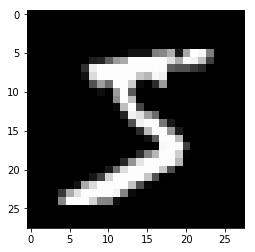

In [11]:
plt.imshow(x_train[a],cmap="gray")

Keras 的 Model 有兩種模型，Sequential 和 Functional ; Sequential 就是一層一層 Layer 疊上去就可以，可以滿足我們大部分的需要 ; Functional 的模型可以做出更多特別的設置，在使用上會比較彈性。

每一層應該有多少神經元 -> 1. 輸入層 : 有多少特徵就有多少神經元   2. 輸出層 : 有多少分類要判斷就有多少最後神經元 3. 隱藏層 : 沒有公式，經驗法則，可試試下列方法再微調 m = 根號(n+1) + a | log(以2為底)n | 根號(nl)，m->隱藏層節點數 | n->輸入層節點數 | l->輸出層節點數 | a->1-10之間的常數

全連接層(Dense Layer)，就是每一個神經元都會貢獻給下一層的神經元

In [12]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()

In [13]:
# 一層隱藏層的模型, 第一個隱藏層要寫出特徵的數目: input_dim
# 因為我們要使用梯度下降, 所以我們需要選擇一組隨機的權重開始
# 通常喜歡使用常態分佈 (random_normal) 來選擇W初始權重
hidden_layer = Dense(units=256, input_dim=784, kernel_initializer="random_normal", activation="relu")
model.add(hidden_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# 多個判斷使用softmax激活函數
output_layer = Dense(units=10, kernel_initializer="random_normal", activation="softmax")
model.add(output_layer)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


每一個輸出,應該要配置一個 bias 常數 (f = wx + b 的 b 常數) 來讓你的激勵函數還是可以保持一樣，所以總數是

權重(Param)的個數->第一隱藏層: 784*256+256(bias 個數)=200960 輸出層: 2560+10(bias 個數)=2570

In [16]:
#模型設置完要compile, optimizer=梯度下降方式, metrics=預設輸出只有loss多少, 這裡多得到的量度是正確率
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [17]:
#開始fit模型
# validation_split=多少用來訓練,多少用來測試
# batch_size=看過多少個樣本更新一次梯度, 這裡建議100~200
# epochs=每一個樣本要看過幾次, 建議10~20開始試
# verbose= 0(不輸出訓練 log) 1(只輸出進度條) 2(每一個 epoch 輸出訓練信息)
train_history = model.fit(x=x_train_shaped, y=y_train_cat, validation_split=0.1, epochs=10, batch_size=200, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
 - 2s - loss: 0.4193 - acc: 0.8875 - val_loss: 0.1778 - val_acc: 0.9523
Epoch 2/10
 - 1s - loss: 0.1783 - acc: 0.9490 - val_loss: 0.1256 - val_acc: 0.9657
Epoch 3/10
 - 1s - loss: 0.1263 - acc: 0.9634 - val_loss: 0.1028 - val_acc: 0.9712
Epoch 4/10
 - 1s - loss: 0.0948 - acc: 0.9723 - val_loss: 0.0877 - val_acc: 0.9772
Epoch 5/10
 - 1s - loss: 0.0750 - acc: 0.9785 - val_loss: 0.0801 - val_acc: 0.9777
Epoch 6/10
 - 1s - loss: 0.0603 - acc: 0.9831 - val_loss: 0.0817 - val_acc: 0.9755
Epoch 7/10
 - 1s - loss: 0.0501 - acc: 0.9859 - val_loss: 0.0761 - val_acc: 0.9782
Epoch 8/10
 - 1s - loss: 0.0415 - acc: 0.9887 - val_loss: 0.0683 - val_acc: 0.9805
Epoch 9/10
 - 1s - loss: 0.0341 - acc: 0.9909 - val_loss: 0.0682 - val_acc: 0.9795
Epoch 10/10
 - 2s - loss: 0.0282 - acc: 0.9929 - val_loss: 0.0712 - val_acc: 0.9788


loss是模型跟所有訓練資料(剛剛切出0.9訓練)正確答案的差距

val_loss是模型跟切出來的驗證資料(我們剛剛切出0.1驗證)正確答案的差距

val_loss沒什麼大的變動的時候(再訓練也對沒看過的資料沒有什麼幫助)就會停下來了，避免過度訓練，可以看到其實10 epoch是差不多的，val_loss已經達到能下降的極致了。

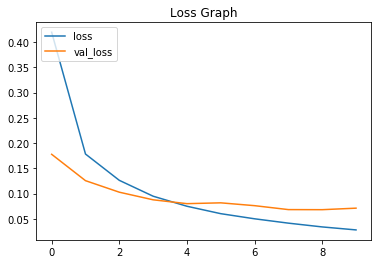

In [18]:
#畫出 loss 和 val_loss 的圖
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

In [19]:
# 取5筆資料來看
pre = model.predict_classes(x_test_shaped)
print("預測標籤:", list(pre[:5]))
print("正確標籤:", list(y_test)[:5])

預測標籤: [7, 2, 1, 0, 4]
正確標籤: [7, 2, 1, 0, 4]


In [20]:
e = model.evaluate(x_test_shaped, y_test_cat)
print("衡量係數:", e)
print("正確率:", e[1] * 100, "%")

10000/10000 [==============================] - 0s 39us/step
衡量係數: [0.069281186634558248, 0.97989999999999999]
正確率: 97.99 %


In [21]:
# 利用混淆矩陣看哪些被分類錯
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, pre))

,0,1,2,3,4,5,6,7,8,9
0,965,1,2,2,1,2,3,1,1,2
1,0,1126,3,1,0,1,2,0,2,0
2,3,3,1007,5,1,0,2,7,4,0
3,0,0,0,991,0,7,0,4,2,6
4,2,0,1,1,961,0,5,0,0,12
5,2,0,0,4,1,873,6,1,4,1
6,2,2,1,1,2,3,946,0,1,0
7,1,3,9,2,1,0,0,1000,2,10
8,1,2,3,7,2,6,1,3,943,6
9,1,2,0,2,10,2,1,4,0,987


列是正確標籤，行是預測標籤，可看出9跟7、4長得很像，較容易被分類錯。